['run732HF.01360']


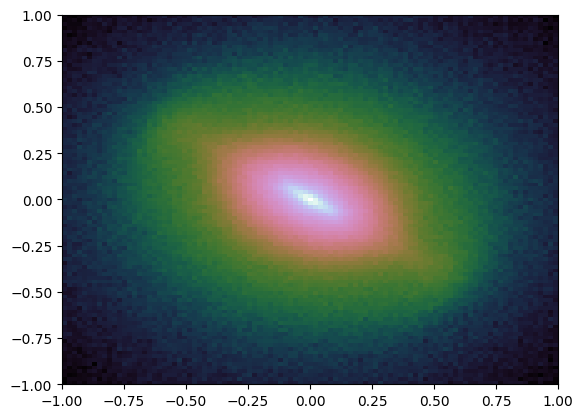

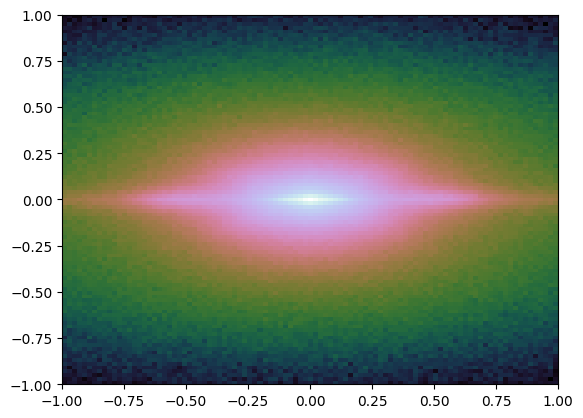

/tmp/ipykernel_511/1215879785.py:123: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(X0_2, Y0_2, density, 15, c='k')


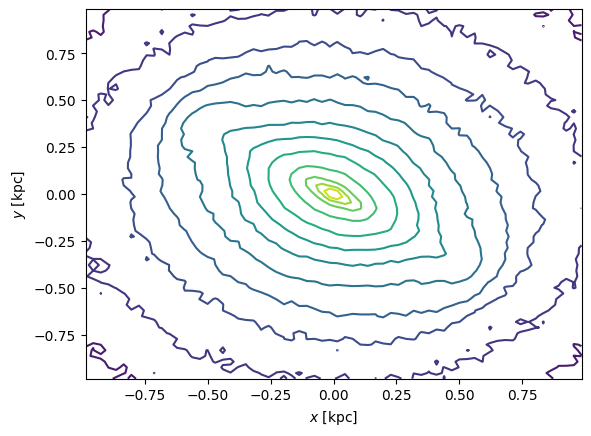

/tmp/ipykernel_511/1215879785.py:132: RuntimeWarning: divide by zero encountered in log10
  density = np.log10(p_den_bins2d.statistic.T)
/tmp/ipykernel_511/1215879785.py:136: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(X0_2, Y0_2, density, 15, c='k')


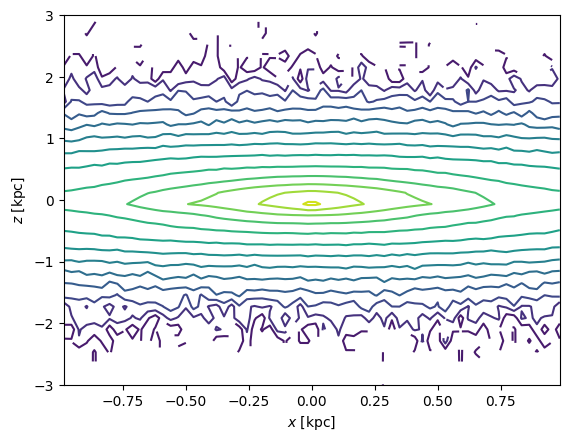

t=20 Angle 143.26, -36.74


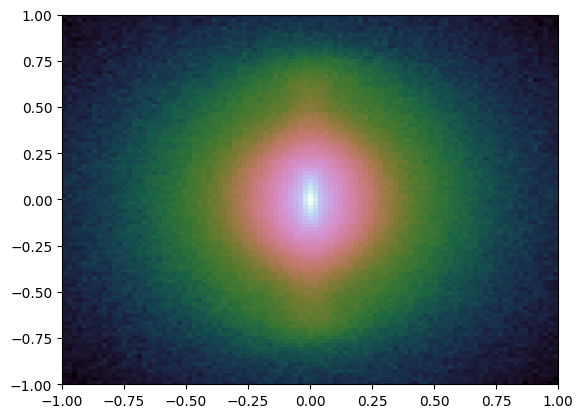

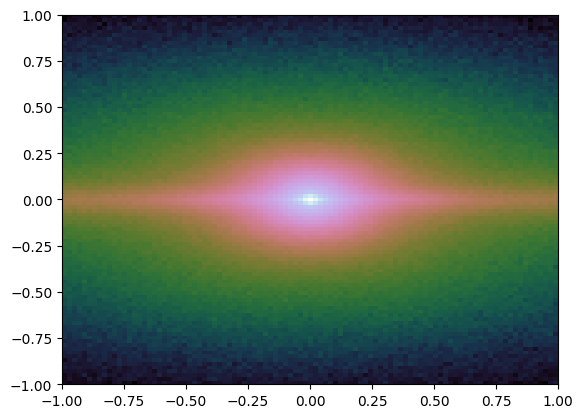

/tmp/ipykernel_511/1215879785.py:211: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(X0_2, Y0_2, density, 15, c='k')


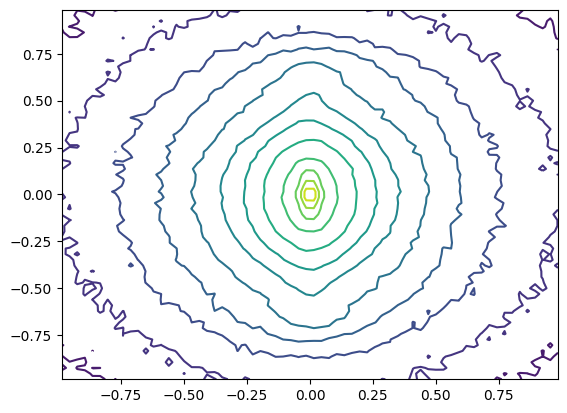

/tmp/ipykernel_511/1215879785.py:218: RuntimeWarning: divide by zero encountered in log10
  density = np.log10(p_den_bins2d.statistic.T)
/tmp/ipykernel_511/1215879785.py:222: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(X0_2, Y0_2, density, 15, c='k')


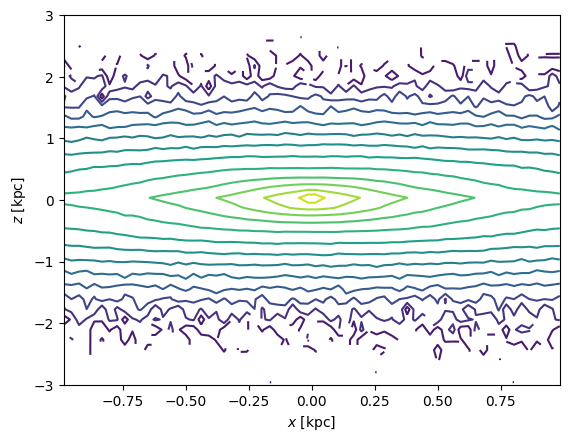

* 1x1 kpc max age: 6.79 Gyr
** Total stars in 1x1 kpc region: 4,390,002 
*** Stars in age group [-1.90506378e-07  4.72682769e+00]: 1,463,438
Bin width:  0.05  kpc -> number of bins: 56
Size of s2p array 1463438
Size of c4p array 1463438
Size of s4p_sum array 56
Size of c4p_sum array 56
Size of sigma_sum array 56
*** Stars in age group [4.72682769 6.14637434]: 1,464,623
Bin width:  0.05  kpc -> number of bins: 76
Size of s2p array 1464623
Size of c4p array 1464623
Size of s4p_sum array 76
Size of c4p_sum array 76
Size of sigma_sum array 76
*** Stars in age group [6.14637434 6.79122553]: 1,463,636
Bin width:  0.05  kpc -> number of bins: 115
Size of s2p array 1463636
Size of c4p array 1463636
Size of s4p_sum array 115
Size of c4p_sum array 115
Size of sigma_sum array 115


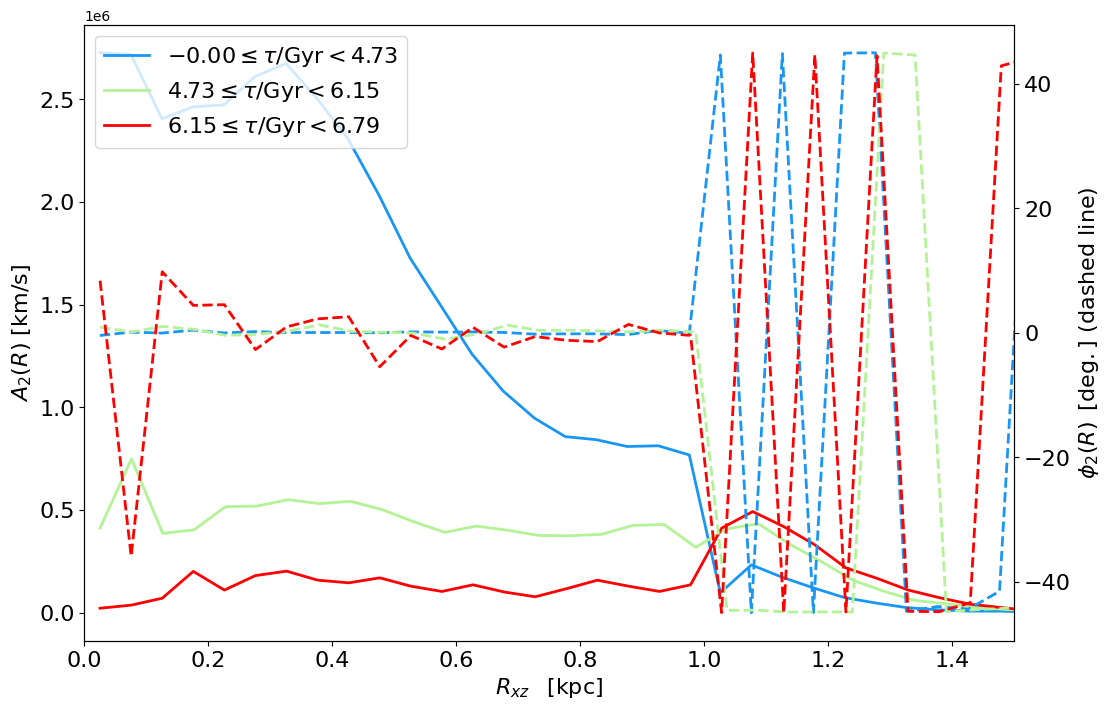

In [1]:
"""
Load model, centre and put midplane into xy the export x, y, z, vx, vy, vz into an .npy file
"""

import pynbody as pb
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.stats as stats
import sys
from scipy.signal import find_peaks
import matplotlib.cm as cm

def refine_mesh(x, y):
    """
    Allows X Y mesh data to be plotted correctly using bin midpoints
    """
    #We now need the centre of the meshes as the edges represent
    #the boundaries of each
    #Chop off the last column, and add half the difference to get the mean
    X0 = x[:,:-1] + np.diff(x)/2
    Y0 = y[:,:-1] + np.diff(y.T)/2

    #No need to keep the last row
    X0 = X0[:-1,:]
    Y0 = Y0[:-1,:]

    return X0, Y0

model_dir = 'run732HF/'
base_dir = '/home/ubuntu/projects/S2B/models/' + model_dir
image_dir = '/home/ubuntu/projects/S2B/images/sigma-shapes/' + model_dir

#Main things to do with a new simulation
#1. Load it
#2. Centre it using 'hyb'
#3. Rotate so the stars are face on
#4. We do NOT align the bar along the x axis as we need to measure its pattern speed

#Then look at the stars, form a numpy array of x y z vx vy vz and save into an numpy array

serial_no = ['{:06d}'.format(x) for x in range(1020, 1520, 20)]
serial_no = ['{:05d}'.format(x) for x in range(2020, 3020, 20)]
serial_no = ['{:05d}'.format(x) for x in range(1020, 2020, 20)]
# serial_no = ['{:06d}'.format(x) for x in range(0, 2610, 10)]   
serial_no = ['{:05d}'.format(x) for x in range(0, 2020, 20)]

fnames = ['run732HF.01360']
print(fnames)

# Control the cyclindrical radius within which we do the centring
I_radius = 1.5

#Rotate the bar so it lies along x?
rotate_model = True
include_mass = True
save_file = True
do_plots = False

mass_fact = 2.362e5
mass_fact = 1

bpa = []    
for fname in fnames:
    
    file = base_dir + fname + '.gz'
    
    #Load the model
    sn = pb.load(file)
    sn.physical_units()
    
    #Step number if we have time steps 0, 20, 40, 60
    # Gyr = int(round(float(fname.split('.')[-1])/1000*5*10))
    # Gyr = int(round(float(fname.split('.')[-1])/1000*10*10))
    # int(round(float(fname.split('.')[-1])/1000*5))
    #10 needed for 708 where we have double the number of files 0, 10, 20, 30
    Gyr = 20

    #Centre the stars using a hybrid method - potential minimum and shrinking sphere
    pb.analysis.halo.center(sn.s, mode='hyb')
    
    #Rotate the simulation so that we see the stars face on
    pb.analysis.angmom.faceon(sn.s)

    #Now align the bar with the x axis. Run per VPD's advice
    #Calculate the x-y plane inertia tensor
    x, y, z = np.array(sn.s['x']), np.array(sn.s['y']), np.array(sn.s['z'])
    m = np.array(sn.s['mass']*mass_fact)
    
    mask = (abs(x) < 1.) & (abs(y) < 1.)
    x, y, z = x[mask], y[mask], z[mask]
    m = m[mask]
    
    plt.hist2d(x,y,bins=(np.linspace(-1,1,100),
              np.linspace(-1,1,100)),cmap='cubehelix',norm=LogNorm())
    plt.show()

    plt.hist2d(x,z,bins=(np.linspace(-1,1,100),
              np.linspace(-1,1,100)),cmap='cubehelix',norm=LogNorm())
    plt.show()

    # Bin size along x in kpc
    bin_size = 0.3
    
    #We require surface density so divisor for pc^-2 is width squared
    density_div = (bin_size * 1000) ** 2
    #Number of bins along x and y are the same
    bins2 = int((20)/bin_size)

    # ================================
    # Plot to check for reasonableness
    # ================================
    mask = (abs(y) < 10) & (abs(x) < 10) 
    p_den_bins2d = stats.binned_statistic_2d(x[mask],
                                    y[mask], m[mask], 'sum', bins=bins2)
    base_bins = (p_den_bins2d.x_edge, p_den_bins2d.y_edge)
    X0, Y0 = np.meshgrid(p_den_bins2d.x_edge, p_den_bins2d.y_edge)
    density = np.log10(p_den_bins2d.statistic.T)
    #We now need the centre of the meshes
    X0_2, Y0_2 = refine_mesh(X0, Y0)
    
    plt.contour(X0_2, Y0_2, density, 15, c='k')
    plt.xlabel(r'$x$ [kpc]')
    plt.ylabel(r'$y$ [kpc]')
    plt.show()

    p_den_bins2d = stats.binned_statistic_2d(x[mask],
                                    z[mask], m[mask], 'sum', bins=bins2)
    base_bins = (p_den_bins2d.x_edge, p_den_bins2d.y_edge)
    X0, Y0 = np.meshgrid(p_den_bins2d.x_edge, p_den_bins2d.y_edge)
    density = np.log10(p_den_bins2d.statistic.T)
    #We now need the centre of the meshes
    X0_2, Y0_2 = refine_mesh(X0, Y0)
    
    plt.contour(X0_2, Y0_2, density, 15, c='k')
    plt.ylim(-3., 3.)
    plt.xlabel(r'$x$ [kpc]')
    plt.ylabel(r'$z$ [kpc]')
    plt.show()


    #Now rotate the galaxy so that the bar lies along the x axis
    #CAN SWITCH OFF AS NEEDED
    if rotate_model == True:
        #Restrict the range of R over which we calculate the tensor so we get the bar only
        r2 = np.hypot(x, y)
        xlt = x[r2 < I_radius]
        ylt = y[r2 < I_radius]
        mlt = m[r2 < I_radius]
        
        #Calculate the inertia tensor; need to have mass in here too in case particles have different masses
        # I_yy, I_xx, I_xy = np.sum(ylt**2), np.sum(xlt**2), np.sum(xlt*ylt)
        I_yy, I_xx, I_xy = np.sum(mlt*ylt**2), np.sum(mlt*xlt**2), np.sum(mlt*xlt*ylt)
        I = np.array([[I_yy, -I_xy], [-I_xy, I_xx]])
        
        #Calculate the eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(I)
        lowest = eigenvalues.argmin()
        maj_axis = eigenvectors[:, lowest]
        
        #Get the angle we need to rotate by
        r_angle1 = np.degrees(np.arctan2(maj_axis[1], maj_axis[0]))
        
        #This analytical calculation is the same so print out just to check
        #Might be 180 degrees off
        r_angle2 = np.degrees(0.5 * np.arctan2(2*I_xy, I_xx-I_yy))
        
        sn.rotate_z(-r_angle1)
    
        print('t={0} Angle {1}, {2}'.format(Gyr, str(np.round(r_angle1,2)), str(np.round(r_angle2,2))))

        # =====================================
        # Rotate now so that the vbar is end on
        # =====================================
        sn.rotate_z(-90)

        # mask = (abs(x) < 1.) & (abs(y) < 1.)
        x, y, z = np.array(sn.s['x']), np.array(sn.s['y']), np.array(sn.s['z'])
        
        plt.hist2d(x,y,bins=(np.linspace(-1,1,100),
                  np.linspace(-1,1,100)),cmap='cubehelix',norm=LogNorm())
        plt.show()
    
        plt.hist2d(x,z,bins=(np.linspace(-1,1,100),
                  np.linspace(-1,1,100)),cmap='cubehelix',norm=LogNorm())
        plt.show()

        x, y, z = np.array(sn.s['x']), np.array(sn.s['y']), np.array(sn.s['z'])
        vx, vy, vz = np.array(sn.s['vx']), np.array(sn.s['vy']), np.array(sn.s['vz'])
        m = np.array(sn.s['mass']*mass_fact)
        age = np.array(sn.s['age'])
        tf = np.array(sn.s['tform'])

        mask = (abs(x) < 1.) & (abs(y) < 1.)
        x, y, z = x[mask], y[mask], z[mask]
        vx, vy, vz = vx[mask], vy[mask], vz[mask]
        m = m[mask]
        age, tf = age[mask], tf[mask]
        
        mask = (abs(y) < 1) & (abs(x) < 1) 
        p_den_bins2d = stats.binned_statistic_2d(x[mask],
                                        y[mask], m[mask], 'sum', bins=bins2)
        base_bins = (p_den_bins2d.x_edge, p_den_bins2d.y_edge)
        X0, Y0 = np.meshgrid(p_den_bins2d.x_edge, p_den_bins2d.y_edge)
        density = np.log10(p_den_bins2d.statistic.T)
        #We now need the centre of the meshes
        X0_2, Y0_2 = refine_mesh(X0, Y0)
        
        plt.contour(X0_2, Y0_2, density, 15, c='k')
        plt.show()

        p_den_bins2d = stats.binned_statistic_2d(x[mask],
                                        z[mask], m[mask], 'sum', bins=bins2)
        base_bins = (p_den_bins2d.x_edge, p_den_bins2d.y_edge)
        X0, Y0 = np.meshgrid(p_den_bins2d.x_edge, p_den_bins2d.y_edge)
        density = np.log10(p_den_bins2d.statistic.T)
        #We now need the centre of the meshes
        X0_2, Y0_2 = refine_mesh(X0, Y0)
        
        plt.contour(X0_2, Y0_2, density, 15, c='k')
        plt.ylim(-3., 3.)
        plt.xlabel(r'$x$ [kpc]')
        plt.ylabel(r'$z$ [kpc]')
        plt.show()


    #Position and vel array of the stellar particles, then save the file; extract the mass also
    # dt = {'names':['x', 'y', 'z', 'vx', 'vy', 'vz', 'm'], \
    #       'formats':[float, float, float, float, float, float, float]}
    
    # dt_no_m = {'names':['x', 'y', 'z', 'vx', 'vy', 'vz'], \
    #       'formats':[float, float, float, float, float, float]}

    # final_array = np.column_stack( (np.array(sn.s['pos']), np.array(sn.s['vel']), np.array(sn.s['mass']*mass_fact))).ravel()
    # final_array.dtype = dt    

    del sn

    plotting = True
    nuclear = True
    log = True
    
    model = "732HF"
    bin_width = 0.05 #kpc
    xlim, ylim = 1., 1. #kpc
    
    stat2d_lst = []
    
    # Divide snapshot into 3 age groups
    max_age = round(max(age),2)
    print('* 1x1 kpc max age: {} Gyr'.format(max_age))
    print('** Total stars in 1x1 kpc region: {:,} '.format(x.shape[0]))
    
    # Sigma statistics and amplitude per age group
    div = 1/3 # Group divider by age, youngest 1/3, intermidiate 1/3 and oldest 1/3
    
    divlr_lst = [[0,div],[div,2*div],[2*div,max_age]]
    age_grp = 0
    
    ag = np.percentile(age, (0., 100/3., 200/3., 100.))
    idx = np.array([(i, i+1) for i in np.arange(0, ag.shape[0]-1)])

    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    ax = axes
    ax2 = ax.twinx()
    xlab = r'$R_{xz} \rm \enspace$ [kpc]'
    ylab = r'$A_2(R)$ [km/s]'
    y2lab = r'$\phi_2(R) \enspace \rm [deg.]$ (dashed line)'
    fs = 16
    colors = cm.rainbow(np.linspace(0.2, 1, idx.shape[0]))
    ax.set_prop_cycle(color=colors)
    ax2.set_prop_cycle(color=colors)
    
    for ai, age_grp in enumerate(ag[idx]):
    # for divlr in divlr_lst:
        # age_grp += 1
        # div_l = divlr[0]
        # div_r = divlr[1]
        # Mask stars between age dividers div_l and div_r
        # mask = ma.masked_inside(s.star['age'], max_age*div_l, max_age*div_r).mask
        # s_grp = s.star[mask]
        mask = (age >= age_grp[0]) & (age <= age_grp[1])
        
        print('*** Stars in age group {}: {:,}'.format(age_grp, mask.sum()))
    
        #Extract phase space data for the model for stars in the group
        z_, x_, y_, vz_, m_ = z[mask], x[mask], y[mask], vz[mask], m[mask]
    
        #Calculate the radius of each particle and its cylindrical angle phi
        R_plot = np.hypot(x_, z_) # Hypotenuse of right angle triangle with x,z
        phis = np.arctan2(z_, x_)
    
        # Calculate bins from a pre-defined bin width in kpc
        bins = int(R_plot.max()/bin_width)
        print("Bin width: ", bin_width, " kpc -> number of bins:", bins)
    
        # Velocity deviation (sigma) statistics IN THE R_PLOT PLANE
        # vd_stat2d, vd_xedges, vd_yedges, vd_binnum2d = stats.binned_statistic_2d(x_, z_, vz_,
        #                 statistic = 'std',
        #                 range = [[-xlim,xlim], [-ylim,ylim]],
        #                 bins = bins)
    
        Fm = 4 # Fourier component 4
        sFp = np.sin(Fm * phis) # for each mass particle = star
        cFp = np.cos(Fm * phis) # for each mass particle = star
    
        # Debug output
        print("Size of s2p array", len(sFp))
        print("Size of c4p array", len(cFp))
    
        # For each radial (xz) bin calculate the sigma (vz)
        vd_stat, edges, binid = stats.binned_statistic(R_plot, vz_, statistic = 'std', bins = bins)
        stat2d_lst.append(vd_stat.T) # We save per group sigma statistics here for multi-panel plotting in teh future

        # For each radial (xz) bin calculate the sigma amp and phase angle
        sFp_binned = stats.binned_statistic(R_plot, sFp, 'sum', bins=bins)
        cFp_binned = stats.binned_statistic(R_plot, cFp, 'sum', bins=bins)
        #sFp_binned = stats.binned_statistic(R_plot, m_ * sFp, 'sum', bins=bins)
        #cFp_binned = stats.binned_statistic(R_plot, m_ * cFp, 'sum', bins=bins)
        #mass_binned = stats.binned_statistic(R_plot, m_, 'sum', bins=bins)
        
        # extracting NP arrays from statistical data
        sFp_sum = sFp_binned.statistic.T
        cFp_sum = cFp_binned.statistic.T
        #mass = mass_binned.statistic.T
        sigma_sum = vd_stat.T
    
        # Debug output
        print("Size of s4p_sum array", len(sFp_sum))
        print("Size of c4p_sum array", len(cFp_sum))
        print("Size of sigma_sum array", len(sigma_sum))
    
        # With Chiara (Nov 2020) we need a factor 1/m (m is Fourier component) for the phase angle of the sigma.
        phiF_plot = (1 / Fm) * np.degrees(np.arctan2(sFp_sum, cFp_sum))
        #a4_plot = np.hypot(sigma_sum * sFp_sum, sigma_sum * cFp_sum)/mass
        aF_plot = np.hypot(sigma_sum * sFp_sum, sigma_sum * cFp_sum)
    
        # Find midpoint of the bins
        radial_bins = sFp_binned.bin_edges[:-1] + np.diff(sFp_binned.bin_edges)/2
    
        # We do not use the following analysis for bars from Stuart code for sigma right now.
        """
        # We wish to locate where, after the initial settling, phi4 changes
        # from constant by more than 10 degrees
        # Set initial settling to be R = 1kpc and extract the first time the
        # absolute value goes above 10 degrees - this is the extent of the bar
        bar_ends_phi2_criterion = 10
        bar_ends_phi2 = phi2_plot[(radial_bins > 1) & (abs(phi2_plot) >=
                               bar_ends_phi2_criterion)][0]
        bar_ends_R_phi2 = radial_bins[(radial_bins > 1) & (abs(phi2_plot) >=
                              bar_ends_phi2_criterion)][0]
    
        # A low estimate for the bar would be half the a2 peak
        # The a2 peak is the first peak in the plot
        # Then find the half peak and its location
        a2_peaks, _ = find_peaks(a2_plot)
        a2_max = a2_plot[a2_peaks[0]]
    
        a2_max_R = radial_bins[a2_peaks[0]]
        bar_ends_a2_criterion = 2
    
        # If this criteria is met then we do not have a bar
        if len(radial_bins[(radial_bins > a2_max_R) &
            (a2_plot <= a2_max/bar_ends_a2_criterion)]) == 0:
            bar_ends_R_phi2, bar_ends_R_a2 = np.nan, np.nan
        # If the bar amplitude a2_max falls below 0.2 then consider the bar unformed
        # and set the radii to be nan
        elif a2_max < 0.2:
            bar_ends_R_phi2, bar_ends_R_a2 = np.nan, np.nan
        else:
            bar_ends_R_a2 = radial_bins[(radial_bins > a2_max_R) &
                                (a2_plot <= a2_max/bar_ends_a2_criterion)][0]
        """
    
        # Plot the amplitude diagram first
        agelab = r'${:0.2f} \leq \tau/\rm{{Gyr}} < {:0.2f}$'.format(age_grp[0], age_grp[1])

        ax.plot(radial_bins, aF_plot, lw=2., label=agelab)
        ax2.plot(radial_bins, phiF_plot, lw=2., ls='--')
        
    ax.tick_params(axis='both', which='both', labelsize=fs)
    ax2.tick_params(axis='both', which='both', labelsize=fs)
    
    ax.set_xlabel(xlab, fontsize=fs)
    ax.set_ylabel(ylab, fontsize=fs)
    
    ax2.set_ylabel(y2lab, fontsize=fs)
    ax.legend(loc='upper left', fontsize=fs)
    
    # We do not plot the analysis conditions for bars from Stuart code for sigma right now.
    #ax.axvline(bar_ends_R_a4, c='r', ls='--')
    #ax.axvline(bar_ends_R_phi4, c='b', ls='--')
    ax.set_xlim(0., 1.5)
    #ax.set_ylim(-3., 3.)
    # ax.set_title(agelab, fontsize=fs)
    
    plt.show()
        # break
